## Step 1: Description of problem and data
This project seeks to accurately identify tweets related to actual disasters. In today's world, where Twitter serves as a key platform for instant communication, being able to quickly discern between tweets signaling real emergencies and those that do not can greatly enhance emergency responses and news reporting. This capability is particularly beneficial for organizations focused on disaster relief and news agencies that rely on timely and accurate information to operate effectively. Considering the overwhelming volume of data generated on social media, manually sorting through tweets is not feasible, making the development of a machine learning model to automate this task crucial. The data provided consists of a train dataset with 7613 values and a test dataset with 3263 values. We are given a tweet in a "text" column as well as keywords and location data for some of the entries in the text column.

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

2024-03-01 15:30:48.883278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
sample_sol = pd.read_csv("sample_submission.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [33]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Step 2: Exploratory Data Analysis
In this step, we dig deeper into our data. We can see that there are 2533 NA values for location and 61 for keyword. As well we see about 43% of the tweets are marked as pertaining to a disaster in our train dataset. The top five locations that people tweeted from are :USA, New York, United States, London, and Canada which indicates difference in the way people reported data (country vs. city vs. state). To clean the data I mainly focused on the text column making all words lower case, getting rid of special characters, removing insignificant words, and lemmatizing the words. 

In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [36]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [37]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [38]:
train.location.value_counts().head()

USA              104
New York          71
United States     50
London            45
Canada            29
Name: location, dtype: int64

In [39]:
train.keyword.value_counts().head()

fatalities    45
deluge        42
armageddon    42
sinking       41
damage        41
Name: keyword, dtype: int64

In [40]:
# cleaning the text getting rid of special characters and numbers
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    return text

train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)

In [41]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

In [42]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_short_tokens(text):
    return " ".join([word for word in text.split() if len(word) > 2])

train['text'] = train['text'].apply(lemmatize_text)
train['text'] = train['text'].apply(remove_short_tokens)
test['text'] = test['text'].apply(lemmatize_text)
test['text'] = test['text'].apply(remove_short_tokens)

## Step 3: Model Architecture
The model I chose used sequential architecture with GRU layers, which I though would be good for NLP due to its capability to capture temporal dependencies in text sequences. The model utilizes word embedding to convert text into a numerical format preserving semantic relationships. The architecture is made of three GRU layers with decreasing units to efficiently process information while mitigating the vanishing gradient problem. Dropout layers are interspersed to prevent overfitting, and the model concludes with dense layers, including a sigmoid activation function for binary output. This setup, combined with the Adam optimizer and binary crossentropy loss, is designed to be computationally efficient and effective at capturing the nuance that exists in text.

In [43]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train['text'])
word_index = tokenizer.word_index

In [44]:
train_sequences = tokenizer.texts_to_sequences(train['text'])
train_padded = pad_sequences(train_sequences, maxlen=100, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(test['text'])
test_padded = pad_sequences(test_sequences, maxlen=100, padding='post', truncating='post')

In [47]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    GRU(units=256, return_sequences=True),
    Dropout(0.2),
    GRU(units=128, return_sequences=True),
    Dropout(0.2),
    GRU(units=64),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
X_train, X_val, y_train, y_val = train_test_split(train_padded, train.target, test_size=0.1, random_state=42)

In [49]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)
class_weights_dict = dict(enumerate(class_weights))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),
                    class_weight=class_weights_dict, verbose=1)

Epoch 1/20
215/215 [==============================] - 48s 195ms/step - loss: 0.6942 - accuracy: 0.5063 - val_loss: 0.6949 - val_accuracy: 0.4409
Epoch 2/20
215/215 [==============================] - 53s 248ms/step - loss: 0.6939 - accuracy: 0.4756 - val_loss: 0.6907 - val_accuracy: 0.5591
Epoch 3/20
215/215 [==============================] - 50s 233ms/step - loss: 0.6942 - accuracy: 0.4820 - val_loss: 0.6946 - val_accuracy: 0.4409
Epoch 4/20
215/215 [==============================] - 41s 192ms/step - loss: 0.6939 - accuracy: 0.4881 - val_loss: 0.6921 - val_accuracy: 0.5591
Epoch 5/20
215/215 [==============================] - 37s 171ms/step - loss: 0.6940 - accuracy: 0.5072 - val_loss: 0.6870 - val_accuracy: 0.5591
Epoch 6/20
215/215 [==============================] - 35s 163ms/step - loss: 0.6934 - accuracy: 0.5100 - val_loss: 0.6925 - val_accuracy: 0.5591
Epoch 7/20
215/215 [==============================] - 36s 169ms/step - loss: 0.6937 - accuracy: 0.4856 - val_loss: 0.6923 - val_ac

In [50]:
predictions = model.predict(test_padded)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

102/102 [==============================] - 5s 36ms/step


In [51]:
final_predictions = pd.DataFrame({'id': test['id'], 'target': binary_predictions})
final_predictions.to_csv('disaster_tweet_sol.csv', index=False)

## Part 4: Results and Analysis 
I iterated on my model three times adding in more layers as well as potential for dropout to minimize overfitting. Pictured below is the file score I achieved via the Kaggle leaderboards as well as the previous iteration of my models. While I did not get a very good score I feel that if I had the time and resources to continue iterating I could improve my score greatly. 


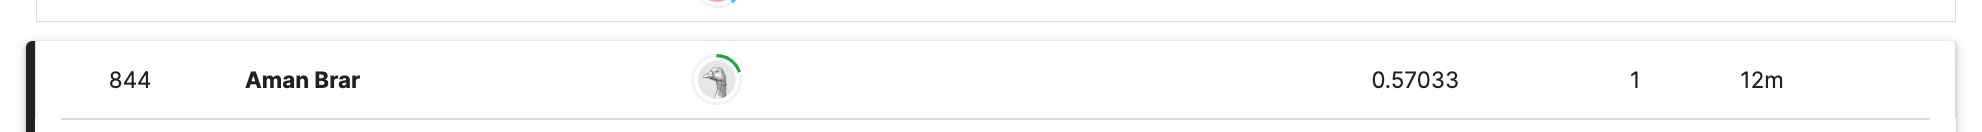

First model iteration
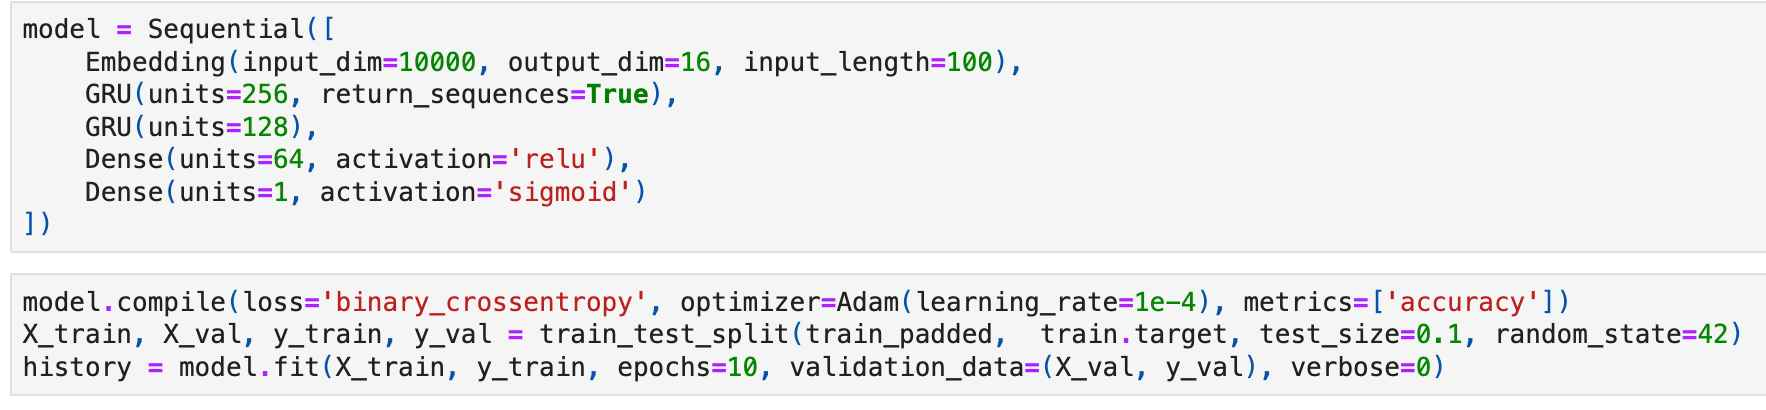

Second model iteration
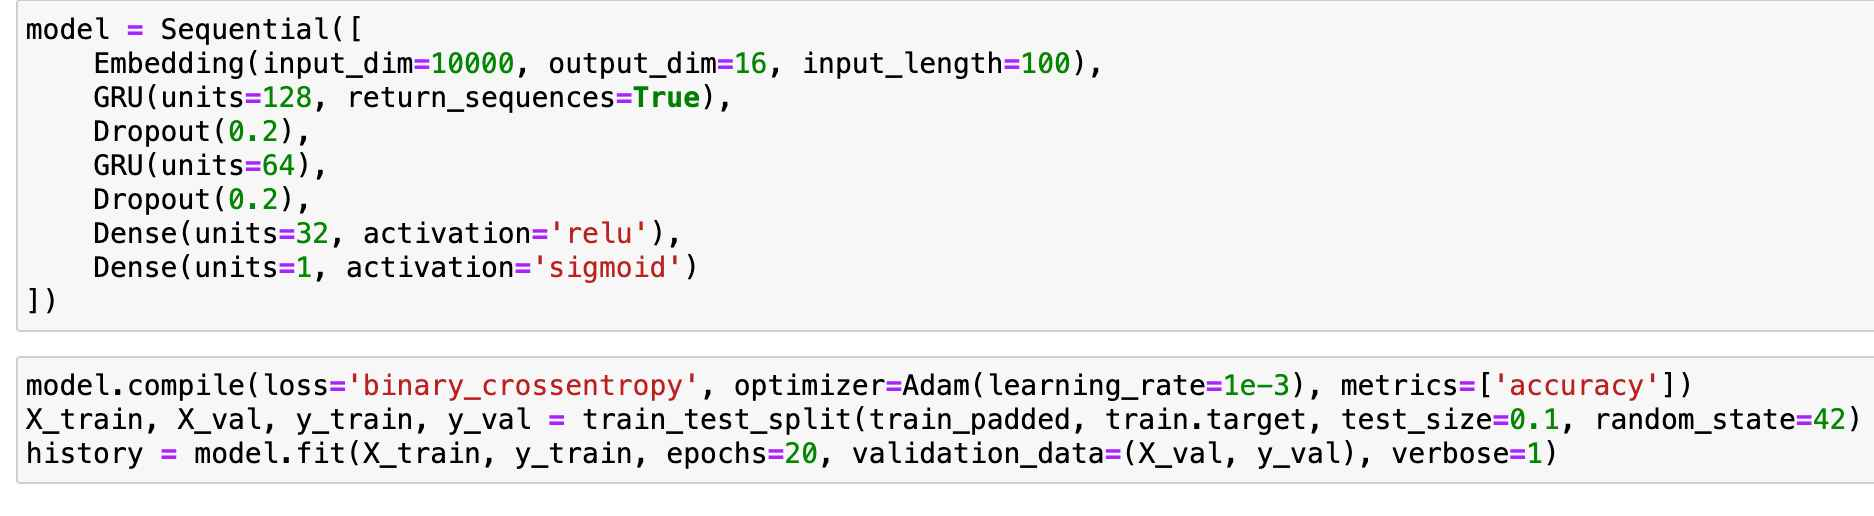

## Step 5: Conclusion
Despite only achieving 57% accuracy I think this project served to establish a pipeline and process I can use in the future when dealing with NLP classification problems. I have done NLP projects before but this was the first time I applied a deep learning approach. There is definetly room for improvement with this model and my ability to apply RNNs in an effective manner, but overall this project introduced a new approach to a very meaningful problem in processing the large amount of information that social media has to offer.